In [ ]:
%%capture
!pip install pafy youtube-dl moviepy

In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant=27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d pypiahmad/realistic-action-recognition-ucf50

realistic-action-recognition-ucf50.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
import os
# Replace 'your_file.zar' with the actual file name
file_path = '/content/realistic-action-recognition-ucf50.zip'
extract_path = '/content/tenp_folder'

# Create extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the .zip file
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

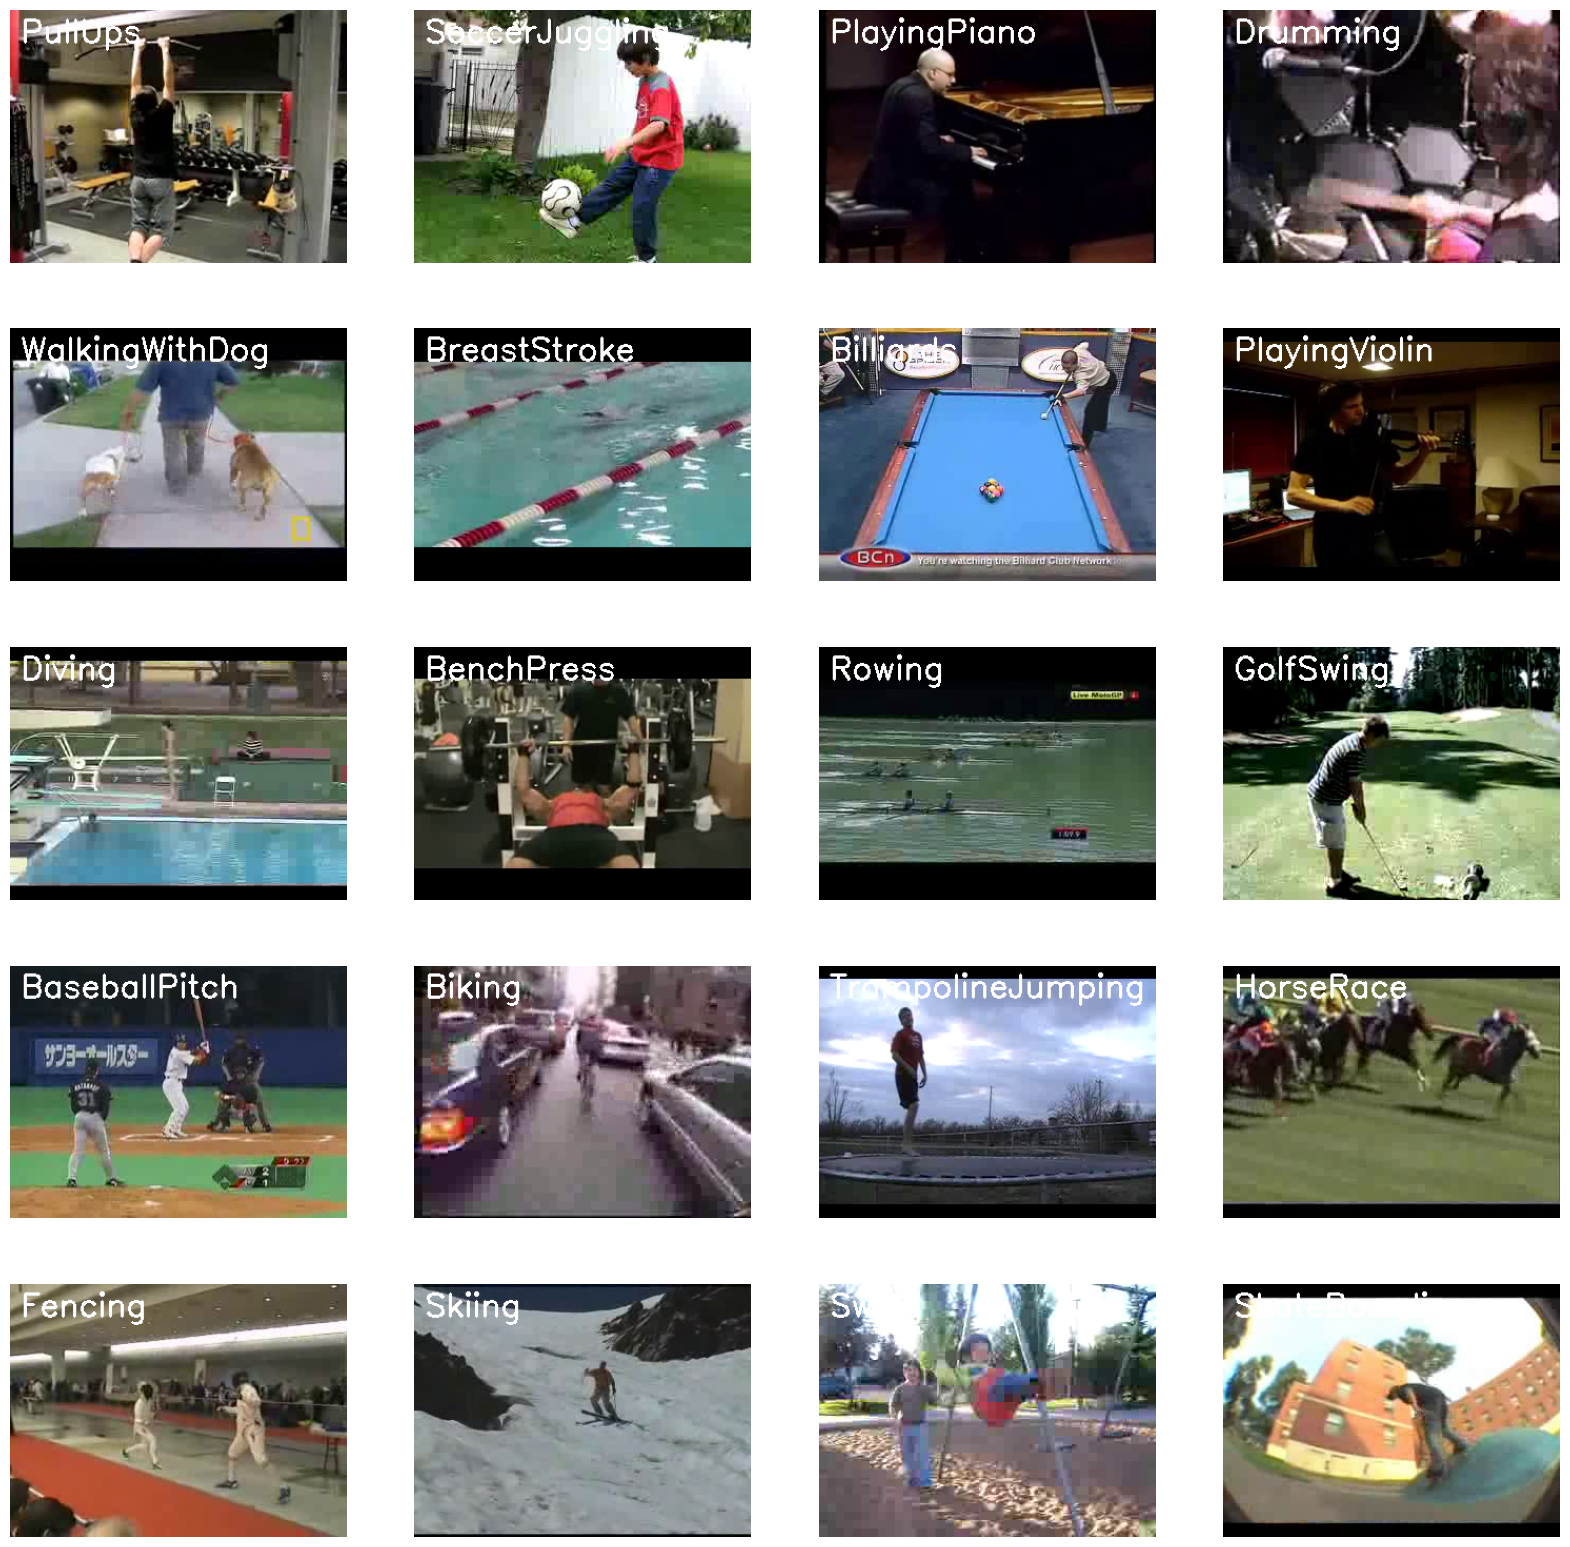

In [ ]:
plt.figure(figsize=(20,20))
all_class_names=os.listdir('/content/tenp_folder/UCF50')
random_range=random.sample(range(len(all_class_names)),20)

for counter,random_index in enumerate(random_range,1):
   selected_class_names=all_class_names[random_index]
   video_files_names_list=os.listdir(f'/content/tenp_folder/UCF50/{selected_class_names}')
   selected_video_file_name=random.choice(video_files_names_list)
   video_reader=cv2.VideoCapture(f'/content/tenp_folder/UCF50/{selected_class_names}/{selected_video_file_name}')
   _,bgr_frame=video_reader.read()
   video_reader.release()
   rgb_frame=cv2.cvtColor(bgr_frame,cv2.COLOR_BGR2RGB)
   cv2.putText(rgb_frame,selected_class_names,(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
   plt.subplot(5,4,counter)
   plt.imshow(rgb_frame)
   plt.axis('off')


In [ ]:
IMAGE_HEIGHT,IMAGE_WIDTH=64,64
SEQUENCE_LENGTH=20
DATASET_DIR='/content/tenp_folder/UCF50'
CLASSES_LIST=['Basketball','Biking','Diving','WalkingWithDog','TaiChi','Swing','PushUps','HighJump','PlayingGuitar']

In [ ]:
def frame_extraction(video_path):
  frames_list=[]
  video_reader=cv2.VideoCapture(video_path)
  video_frames_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window=max(int(video_frames_count/SEQUENCE_LENGTH),1)
  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter*skip_frames_window)
    success,frame=video_reader.read()
    if not success:
      break
    resized_frame=cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))
    normalized_frame=resized_frame/255
    frames_list.append(normalized_frame)
  video_reader.release()
  return frames_list




In [ ]:
def create_dataset():
  features=[]
  labels=[]
  video_file_paths=[]
  for class_index,class_name in enumerate(CLASSES_LIST):
    print(f'extracting data of class:{class_name}')
    file_list=os.listdir(os.path.join(DATASET_DIR,class_name))
    for file_name in file_list:
      video_file_path=os.path.join(DATASET_DIR,class_name,file_name)
      frames=frame_extraction(video_file_path)
      if len(frames)==SEQUENCE_LENGTH:
        features.append(frames)
        labels.append(class_index)
        video_file_paths.append(video_file_path)
  features=np.asarray(features)
  labels=np.array(labels)
  return features,labels,video_file_path



In [ ]:
features,labels,video_file_path=create_dataset()

extracting data of class:Basketball
extracting data of class:Biking
extracting data of class:Diving
extracting data of class:WalkingWithDog
extracting data of class:TaiChi
extracting data of class:Swing
extracting data of class:PushUps
extracting data of class:HighJump
extracting data of class:PlayingGuitar


In [ ]:
features.shape

(1184, 20, 64, 64, 3)

In [ ]:
one_hot_encoded_labels=to_categorical(labels)

In [ ]:
from sklearn.model_selection import train_test_split
features_train,features_test,labels_train,labels_test=train_test_split(features,one_hot_encoded_labels,test_size=0.25,shuffle=True,random_state=seed_constant)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout,Flatten,Dense


In [ ]:
def create_covlstm_model():
  model=Sequential()
  model.add(ConvLSTM2D(filters=4,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True,input_shape=(SEQUENCE_LENGTH,IMAGE_HEIGHT,IMAGE_WIDTH,3)))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))
  model.add(ConvLSTM2D(filters=8,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))
  model.add(ConvLSTM2D(filters=14,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))
  model.add(ConvLSTM2D(filters=16,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(Flatten())
  model.add(Dense(len(CLASSES_LIST),activation="softmax"))
  model.summary()
  return model



In [ ]:
convlstm_model=create_covlstm_model()
print('moddel created succesfully')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 20, 31, 31, 4)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 20, 31, 31, 4)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 20, 15, 15, 8)     0         
 g3D)                                                            
                                                        

In [ ]:
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=10,mode='min',restore_best_weights=True)
convlstm_model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
history=convlstm_model.fit(x=features_train,y=labels_train,epochs=50,shuffle=True,validation_split=0.2,callbacks=[early_stopping_callback])

Epoch 1/50
23/23 [==============================] - 22s 492ms/step - loss: 0.2095 - accuracy: 0.9254 - val_loss: 0.9152 - val_accuracy: 0.7640
Epoch 2/50
23/23 [==============================] - 10s 445ms/step - loss: 0.1455 - accuracy: 0.9535 - val_loss: 1.0397 - val_accuracy: 0.7191
Epoch 3/50
23/23 [==============================] - 14s 608ms/step - loss: 0.1022 - accuracy: 0.9817 - val_loss: 0.8817 - val_accuracy: 0.7753
Epoch 4/50
23/23 [==============================] - 10s 433ms/step - loss: 0.0907 - accuracy: 0.9845 - val_loss: 0.9087 - val_accuracy: 0.7135
Epoch 5/50
23/23 [==============================] - 10s 432ms/step - loss: 0.0710 - accuracy: 0.9873 - val_loss: 0.8411 - val_accuracy: 0.7865
Epoch 6/50
23/23 [==============================] - 10s 416ms/step - loss: 0.0940 - accuracy: 0.9704 - val_loss: 1.1984 - val_accuracy: 0.7135
Epoch 7/50
23/23 [==============================] - 9s 396ms/step - loss: 0.0881 - accuracy: 0.9831 - val_loss: 0.8117 - val_accuracy: 0.7753


In [ ]:
model_evaluate_history=convlstm_model.evaluate(features_test,labels_test)

10/10 [==============================] - 1s 74ms/step - loss: 0.9714 - accuracy: 0.7500


In [ ]:
def download_youtube_videos(youtube_video_url,out_directory):
  video=pafy.new(youtube_video_url)
  title=video.title
  video_best=video.getbest()
  output_file_path=f'{out_directory}/{title}.mp4'
  video_best.download(filepath=output_file_path,quiet=True)
  return title

In [ ]:
def frame_extraction(video_path):
  frames_list=[]
  video_reader=cv2.VideoCapture(video_path)
  video_frames_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window=max(int(video_frames_count/SEQUENCE_LENGTH),1)
  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter*skip_frames_window)
    success,frame=video_reader.read()
    if not success:
      break
    resized_frame=cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))
    normalized_frame=resized_frame/255
    frames_list.append(normalized_frame)
  video_reader.release()
  return frames_list

In [ ]:
features=[]
video_file_path='/content/v_PushUps_g09_c01.avi'
frames=frame_extraction(video_file_path)
if len(frames)==SEQUENCE_LENGTH:
        features.append(frames)
features=np.asarray(features)
predicted_label_probabilities=convlstm_model.predict(features)[0]
predicted_label=np.argmax(predicted_label_probabilities)
print(predicted_label)




1/1 [==============================] - 0s 54ms/step
6


In [ ]:
convlstm_model.save('/content/tenp_folder/human_action_recognition.h5')